# Module 4 Final Project Submission

- Student Name: John Casey Dean
- Student Pace: Part Time
- Scheduled Review: 11-3-2020 19:15
- Instructor Name: Lindsey Berlin
- Blog Post URL: https://www.apogeecoding.com/blog/my-first-nlp-project



# Summary



In this project we attempt to create a model that will correctly classify a tweet as positive, negative, or neutral. Our priority was first to classify positive tweets, then negative tweets. Neutral tweets were not prioritized. Our model performed fairly well in some areas and not so well in others. Where it predicted a positive or negative emotion from a tweet, it was right the overwhelming majority of the time. It predicted quite a few positive or negative tweets as nuetral, however, which suggests that further tuning is needed.


# Introduction

As the internet and social media become ever present in our lives, the amount of text data we interact with is growing at a rate that is honestly difficult to wrap our heads around. There are over 500 million tweets every day.  Yelp hosts nearly 200 million reviews. The amount of text data available to us is simply staggering. With that in mind, it’s imperative that we find ways to take this wealth of data and turn it into actionable insights to solve the problems we encounter every day. In our case, the problem we are attempting to solve is how to conduct effective sentiment analysis. Knowing how your company and its products are being viewed by the public is key to developing a successful plan for product releases, feature updates, social media presence, and other decisions that encompass every aspect of your business.


# Conclusion

Our model failed to correctly classify most positive or negative tweets. It did, however have a high success rate when it did classify a tweet as negative or positive. 100% of the tweets it classified as negative were actually negative, and 67% of the predicted positives were in fact positive. This suggests that the model could be improved by adjusting probability thresholds for classifying as positive or negative, or by using multiple binary classification models instead of multinomial classification.

# Preprocessing and EDA
## Previewing the File

As this dataset is primarily text data, we had to approach it a little differently from our previous projects that were composed primarily of numerical data. To this end, our first step was to open the 'tweets.csv' file in Excel or Sheets to try to get a feel for what kind of preprocessing steps may be required. Below is a screenshot of the first few lines of the data in Excel.

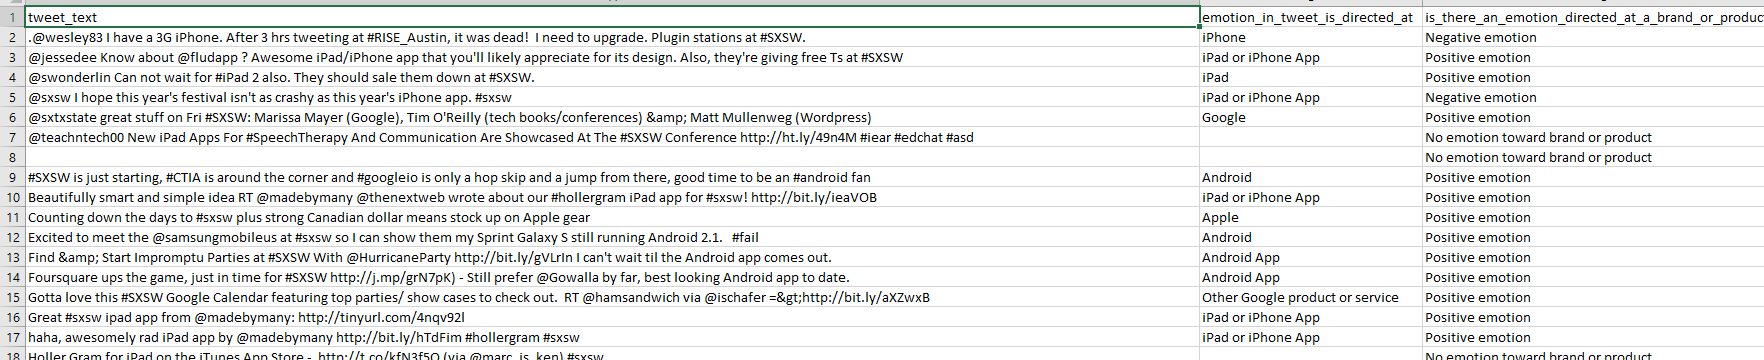

Scrolling through the file, we can see that there are several decisions we will have to answer over the course of our project.

- How do we deal with missing data?
- Is there a difference between "I can't tell" and "No emotion toward brand or product"?
- Do we want to gauge sentiment for specific brands and products or just sentiment overall?
- Do neutral tweets matter to our model, and if so do we have an imbalanced data problem?
- How do we handle mentions and hashtags?

All of these are questions that must be answered before we can begin building a model that works for us. We will begin by working through the first two problems and then setting up our data set for success in answering the remaining questions.

## Importing Libraries and Data

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk # Our NLP package
from nltk.tokenize import TweetTokenizer # A tokenizer that will strip mentions out of our tweets
from nltk.tokenize import word_tokenize # A standard tokenizer
from nltk.corpus import stopwords # A list of stopwords to remove from our tweets
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import re

In [42]:
# Importing the dataset and checking that it imported properly
df = pd.read_csv('tweets.csv', encoding = 'ansi')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# Preprocessing

Before we begin, our column headings are unnecessarily verbose. For readability, lets rename our columns, then let's look at the question of missing data.

In [43]:
df.rename(columns= {'tweet_text' : 'text', 
                    'emotion_in_tweet_is_directed_at' : 'product or brand', 
                    'is_there_an_emotion_directed_at_a_brand_or_product' : 'emotion'}, 
          inplace = True)

### Missing Values

In [44]:
df.isna().sum()

text                   1
product or brand    5802
emotion                0
dtype: int64

Here we see there is a tweet with no text in it. We can safely remove that single tweet. As for the 5802 missing in 'product or brand', we will insert 'unknown'.

In [45]:
df['product or brand'].fillna(value = 'Unknown', inplace = True)

In [46]:
df.isna().sum()

text                1
product or brand    0
emotion             0
dtype: int64

In [47]:
df.dropna(axis=0, inplace=True)

In [48]:
df.isna().sum()

text                0
product or brand    0
emotion             0
dtype: int64

### "I can't tell" vs "No emotion toward brand or product"
We've filled in all of our missing values! Now we'll move on to our question about classifications!

In [49]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

Let's take samples from the observations marked "no emotion", and those marked "I can't tell" and compare to see if there is a difference.

In [50]:
no_emotion_df = df[df['emotion'] == 'No emotion toward brand or product']
cant_tell_df = df[df['emotion'] == 'I can\'t tell']

In [51]:
no_emotion_df.reset_index().head()

,index,text,product or brand,emotion
0,5,@teachntech00 New iPad Apps For #SpeechTherapy...,Unknown,No emotion toward brand or product
1,16,Holler Gram for iPad on the iTunes App Store -...,Unknown,No emotion toward brand or product
2,32,"Attn: All #SXSW frineds, @mention Register fo...",Unknown,No emotion toward brand or product
3,33,Anyone at #sxsw want to sell their old iPad?,Unknown,No emotion toward brand or product
4,34,Anyone at #SXSW who bought the new iPad want ...,Unknown,No emotion toward brand or product


In [52]:
cant_tell_df.reset_index().head()

,index,text,product or brand,emotion
0,90,Thanks to @mention for publishing the news of ...,Unknown,I can't tell
1,102,‰ÛÏ@mention &quot;Apple has opened a pop-up st...,Unknown,I can't tell
2,237,Just what America needs. RT @mention Google to...,Unknown,I can't tell
3,341,The queue at the Apple Store in Austin is FOUR...,Unknown,I can't tell
4,368,Hope it's better than wave RT @mention Buzz is...,Unknown,I can't tell


As we can see, both categories seem to include tweets that are either purely informational, or are too vague to judge emotion from. For simplicity we will treat both categories as 'No emotion'. Since our models will need these targets to be numerical, we will also rename the categories to numbers. 1 for positive, 0 for neutral, -1 for negative.

In [53]:
# Function for renaming our emotion column
def rename_emotion(x):
    if (x == 'No emotion toward brand or product') | (x == 'I can\'t tell') :
        x = 0
    elif x == 'Positive emotion':
        x = 1
    elif x == 'Negative emotion' :
        x = -1
        
    return x

In [54]:
df['emotion'] = df.emotion.apply(rename_emotion)

In [55]:
df.emotion.value_counts()

 0    5544
 1    2978
-1     570
Name: emotion, dtype: int64

This looks much better and certainly less verbose. Now we just have to tokenize our data and clean that up a bit before moving on to actually building our model.

## Functions

In [56]:
def strip_data(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    
    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    
    #Removing special characters
    data = re.sub(r'[*!+&?^%$#.\/:,;}{)(%]', r'', data)
    
    return data

In [57]:
def remove_stopwords(words, stopwords):
    words = [word.lower() for word in words if word.lower() not in stopwords]
    return words

In [58]:
def lem_words(words, stemmer):
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

In [59]:
#stripping special characters and converting all words to lower case
df['text'] = df['text'].apply(strip_data).str.lower()
df['text'].head()

0    @wesley83 i have a 3g iphone after 3 hrs tweet...
1    @jessedee know about @fludapp  awesome ipadiph...
2    @swonderlin can not wait for ipad 2 also they ...
3    @sxsw i hope this years festival isnt as crash...
4    @sxtxstate great stuff on fri sxsw marissa may...
Name: text, dtype: object

In [60]:
#tokenizing text, including removing mentions
tknzr = TweetTokenizer(strip_handles=True)
df['text'] = df['text'].apply(tknzr.tokenize)

In [61]:
df['text'][0]

['i',
 'have',
 'a',
 '3g',
 'iphone',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 'rise_austin',
 'it',
 'was',
 'dead',
 'i',
 'need',
 'to',
 'upgrade',
 'plugin',
 'stations',
 'at',
 'sxsw']

In [62]:
#import nltk stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [63]:
stopwords = [word.lower() for word in stopwords]

In [64]:
df['text'] = df.text.apply(remove_stopwords, args=(stopwords,))
df['text'][0]

['3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [65]:
lemmatizer = WordNetLemmatizer()

In [66]:
df['text'] = df.text.apply(lem_words, args=(lemmatizer,))
df['text'][0]

['3g',
 'iphone',
 '3',
 'hr',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw']

# EDA

In [67]:
tweet_raw = []
for tweet in df['text'] :
    tweet_raw += tweet

In [68]:
tweet_fq = FreqDist(tweet_raw)
tweet_fq.most_common(50)

[('sxsw', 9539),
 ('link', 4295),
 ('rt', 2957),
 ('ipad', 2899),
 ('google', 2522),
 ('apple', 2251),
 ('2', 1643),
 ('iphone', 1518),
 ('store', 1505),
 ('-', 1308),
 ('new', 1089),
 ('austin', 962),
 ('app', 811),
 ('amp', 722),
 ('‰', 691),
 ('launch', 688),
 ('social', 641),
 ('circle', 640),
 ('today', 573),
 ('android', 566),
 ('network', 471),
 ('get', 454),
 ('line', 440),
 ('via', 435),
 ('pop-up', 396),
 ('free', 383),
 ('party', 379),
 ('called', 361),
 ('sxswi', 338),
 ('mobile', 335),
 ('one', 313),
 ('major', 302),
 ('time', 301),
 ('like', 298),
 ('day', 278),
 ('map', 267),
 ('temporary', 264),
 ('u', 259),
 ('opening', 256),
 ('im', 251),
 ('open', 250),
 ('possibly', 244),
 ('win', 242),
 ('need', 238),
 ('go', 234),
 ('come', 227),
 ('apps', 226),
 ('people', 226),
 ('see', 226),
 ('downtown', 222)]

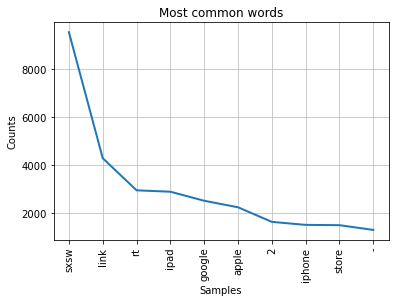

<AxesSubplot:title={'center':'Most common words'}, xlabel='Samples', ylabel='Counts'>

In [69]:
most_common = FreqDist(dict(tweet_fq.most_common(10)))
most_common.plot(title='Most common words')

In [70]:
df_pos = df[df['emotion'] == 1]
df_neg = df[df['emotion'] == -1]

In [71]:
pos_tweet_raw = []
for tweet in df_pos['text'] :
    pos_tweet_raw += tweet

In [72]:
neg_tweet_raw = []
for tweet in df_neg['text'] :
    neg_tweet_raw += tweet

In [73]:
pos_tweet_fq = FreqDist(pos_tweet_raw)
neg_tweet_fq = FreqDist(neg_tweet_raw)

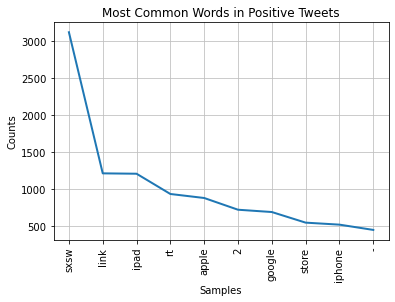

<AxesSubplot:title={'center':'Most Common Words in Positive Tweets'}, xlabel='Samples', ylabel='Counts'>

In [74]:
most_common_pos = FreqDist(dict(pos_tweet_fq.most_common(10)))
most_common_pos.plot(title='Most Common Words in Positive Tweets')

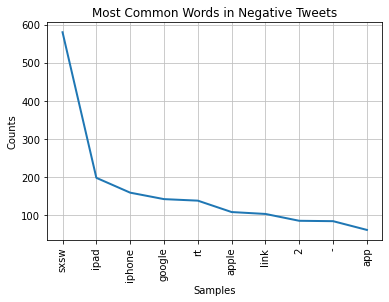

<AxesSubplot:title={'center':'Most Common Words in Negative Tweets'}, xlabel='Samples', ylabel='Counts'>

In [75]:
most_common_neg = FreqDist(dict(neg_tweet_fq.most_common(10)))
most_common_neg.plot(title='Most Common Words in Negative Tweets')

As we can see, there is significant overlap in the most common words. This most likely means that these words will carry very little weight in our model.

## The Model

For our first model, we will use Naive Bayes Multinomial classifier. We have chosen this model due to it's straightforward implementation and the fact that it should give us some idea as to what the next iteration of our model will look like.

In [76]:
df_for_tfidf = df
df_for_tfidf['text'] = df_for_tfidf.text.apply(lambda x : " ".join(x))

In [77]:
df_for_tfidf['text'][0]

'3g iphone 3 hr tweeting rise_austin dead need upgrade plugin station sxsw'

In [78]:
# Grabbing our inputs and target
X = df_for_tfidf['text']
y = df_for_tfidf['emotion']

In [79]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)

In [80]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords, 
                        max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

In [81]:
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [82]:
# checking that the vectorization worked
row1 = tfidf_test_df.iloc[0]

row1.loc[row1 > 0].sort_values(ascending=False)

design        0.410812
panel         0.397192
redeem        0.328122
fell          0.328122
computing     0.306369
cloud         0.288800
pr            0.279426
experience    0.251118
hope          0.235807
one           0.168328
android       0.148632
today         0.148250
iphone        0.108302
Name: 0, dtype: float64

Train Accuracy: 0.7509898812142543
Test Accuracy: 0.6709194896612406


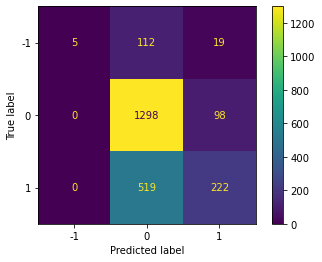

In [83]:
# fitting and checking the model
nb_tfidf = MultinomialNB()

Xtrain_transformed = tfidf.fit_transform(X_train)
Xtest_transformed = tfidf.transform(X_test)

nb_tfidf.fit(Xtrain_transformed, y_train)

train_preds = nb_tfidf.predict(Xtrain_transformed)
test_preds = nb_tfidf.predict(Xtest_transformed)

print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
plot_confusion_matrix(nb_tfidf, Xtest_transformed, y_test,
                          values_format=".4g")  # to make numbers readable
plt.show()

As you can see, this model is fine, but it has room for improvement. Some ideas are making predictions based on our predict_proba for the model, as well as using multiple binary classifiers to predict positive or negative emotion instead of multinomial classifier. 

In [84]:
proba_test = nb_tfidf.predict_proba(Xtest_transformed)

In [85]:
proba_test

array([[0.03185335, 0.74062609, 0.22752056],
       [0.01380076, 0.47163942, 0.51455983],
       [0.03921256, 0.44142095, 0.51936649],
       ...,
       [0.00735572, 0.46945676, 0.52318752],
       [0.03078145, 0.54049078, 0.42872777],
       [0.03274775, 0.61550734, 0.35174491]])

In [86]:
proba_test_neg = [x[0] for x in proba_test]
proba_test_pos = [x[1] for x in proba_test]
proba_test_neu = [x[2] for x in proba_test]

In [87]:
proba_test_neg

[0.03185334551677063,
 0.013800758477368266,
 0.039212555226349734,
 0.06392532287536194,
 0.03227056341578264,
 0.003390745336397424,
 0.010049138941280652,
 0.0027901372336145563,
 0.02642169330428691,
 0.0005309700531716455,
 0.012745367567439719,
 0.036146218786958575,
 0.01129077804838564,
 0.034005017322585616,
 0.026336941863291777,
 0.00868329153546409,
 0.014593594905622976,
 0.029469237969781206,
 0.033779368978827946,
 0.03327069928208695,
 0.012957864389188023,
 0.0003694453521298031,
 0.0193963443950094,
 0.01627068868013356,
 0.02071575614011035,
 0.012363126458605317,
 0.01899645209881062,
 0.0003634545511685802,
 0.010806794451592086,
 0.02030505294561444,
 0.009322780421508048,
 0.058101596172920364,
 0.014007496049041467,
 0.004732926331664299,
 0.040279758904442055,
 0.012288179895067176,
 0.004622713207125915,
 0.0061890084369496424,
 0.021119511891153558,
 0.030591835704305778,
 0.01408802733967305,
 0.06222109289896712,
 0.0066979362636066945,
 0.06461860323099548

In [88]:
proba_df1 = pd.Series(proba_test_neg)
proba_df2 = pd.Series(proba_test_neu)
proba_df3 = pd.Series(proba_test_pos)
proba_df = pd.concat([proba_df1,proba_df2, proba_df3], axis = 1)

In [89]:
proba_df.head()

,0,1,2
0,0.031853,0.227521,0.740626
1,0.013801,0.514560,0.471639
2,0.039213,0.519366,0.441421
3,0.063925,0.210580,0.725495
4,0.032271,0.561214,0.406515


In [90]:
proba_df.columns = ['negative', 'neutral', 'positive']

In [91]:
proba_df['target'] = df['emotion']

In [92]:
nb_tfidf.classes_

array([-1,  0,  1], dtype=int64)

In [93]:
proba_df.head(10)

,negative,neutral,positive,target
0,0.031853,0.227521,0.740626,-1.0
1,0.013801,0.514560,0.471639,1.0
2,0.039213,0.519366,0.441421,1.0
3,0.063925,0.210580,0.725495,-1.0
4,0.032271,0.561214,0.406515,1.0
5,0.003391,0.348165,0.648445,0.0
6,0.010049,0.449049,0.540902,NaN
7,0.002790,0.274781,0.722429,1.0
8,0.026422,0.390794,0.582785,1.0
9,0.000531,0.075693,0.923776,1.0


In [94]:
proba_df['Prediction'] = pd.Series(test_preds)

In [96]:
proba_df.head(10)

,negative,neutral,positive,target,Prediction
0,0.031853,0.227521,0.740626,-1.0,0
1,0.013801,0.514560,0.471639,1.0,1
2,0.039213,0.519366,0.441421,1.0,1
3,0.063925,0.210580,0.725495,-1.0,0
4,0.032271,0.561214,0.406515,1.0,1
5,0.003391,0.348165,0.648445,0.0,0
6,0.010049,0.449049,0.540902,NaN,0
7,0.002790,0.274781,0.722429,1.0,0
8,0.026422,0.390794,0.582785,1.0,0
9,0.000531,0.075693,0.923776,1.0,0
